### PART 1: FC BARCELONA PERFORMANCE TRENDS OVER TIME
- This part aims to show and analyze FC Barcelona's performace in both Domestic League and International Competition (the UEFA Champions League)

In [2]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# load needed dataset for analysis
df1 = pd.read_html('https://fbref.com/en/squads/206d90db/history/Barcelona-Stats-and-History#all_comps_fa_club_league', attrs={"id" : "comps_fa_club_league"})[0]
df1.to_csv('./data/raw/la_liga_stats.csv')
df2 = pd.read_html('https://fbref.com/en/squads/206d90db/history/Barcelona-Stats-and-History#all_comps_fa_club_league', attrs={"id" : "comps_intl_club_cup"})[0]
df2.to_csv('./data/raw/champions_league_stats.csv')
df3 = pd.read_csv('./data/processed/fcb_deeper_stats.csv')
df4 = pd.read_csv('./data/processed/squad_cost_limit.csv')
df5 = pd.read_csv('./data/processed/transfer_spending.csv')

# drop irrelevant columns and rows
df1 = df1.drop([0] + list(range(12, 38))).reset_index(drop=True)
df1 = df1.drop(['Country', 'Attendance', 'Top Team Scorer', 'Goalkeeper' , 'Notes'], axis=1)
indices_to_drop = df3[df3['Ball Situation'] == 'Set piece'].index
df3 = df3.drop(indices_to_drop).reset_index(drop=True)
df4 = df4.drop(list(range(0, 5))).reset_index(drop=True)

# data cleaning
df1.rename(columns={"Comp" : "Domestic Comp", "LgRank" : "Domestic Rank", "MP" : "Domestic Match Played", 
                    "W" : "Domestic W", "D" : "Domestic D", "L" : "Domestic L", "GF" : "Total GF", 
                    "GA" : "Total GA", "GD" :"Domestic GD", "Pts" : "Domestic Pts"}, inplace=True)
df1["Season"] = df1["Season"].str.split("-").apply(lambda x: x[0][2:] + "/" + x[1][2:])
df1 = df1.sort_values("Season").reset_index(drop=True)
merged_df = pd.merge(df1, df3, on=['Season'], how='right')

# strip any space if any
merged_df.columns = merged_df.columns.str.strip()
merged_df.to_csv('./data/processed/laliga_season_level_stats.csv')

# clean dataset
df2 = df2.drop([0] + list(range(14, 38))).reset_index(drop=True)
df2 = df2.drop(['Attendance', 'Top Team Scorer', 'Goalkeeper', 'Notes', 'Squad'], axis=1)

# cleaning and transforming data for later visualization
df2.rename(columns={"Comp" : "Intl Comp", "LgRank" : "Stage Reached", "MP" : "UCL Match Played", 
                    "W" : "UCL W", "D" : "UCL D", "L" : "UCL L", "GF" : "UCL GF", 
                    "GA" : "UCL GA", "GD" :"UCL GD", "Pts" : "UCL Pts"}, inplace=True)
df2 = df2.astype({'UCL Match Played' : 'int', 'UCL W' : 'int', 'UCL D' : 'int', 'UCL L' : 'int', 'UCL GF' : 'int', 
                  'UCL GA' : 'int', 'UCL GD' : 'int', 'UCL Pts' : 'int'})
df2['Season'] = df2['Season'].str.split("-").apply(lambda x: x[0][2:] + "/" + x[1][2:])
df2 = df2.sort_values("Season").reset_index(drop=True)


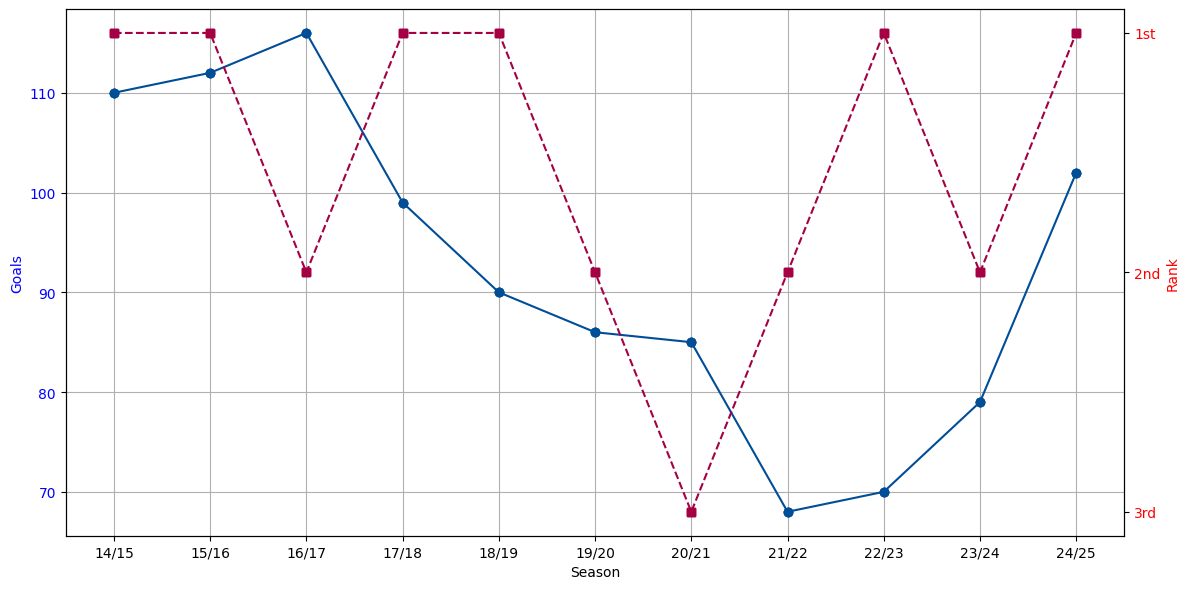

In [3]:
# stats visualize
## ========== PLOT 1: Goals & Rank ==========
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(merged_df["Season"], merged_df["Total GF"], marker='o', color='#004D98', label="Total Goals")
ax1.set_xlabel("Season")
ax1.set_ylabel("Goals", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)
plt.tight_layout()

ax2 = ax1.twinx()
ax2.plot(merged_df["Season"], merged_df["Domestic Rank"], marker='s', color='#A50044', linestyle="--", label="Rank")
ax2.set_xlabel("Season")
ax2.set_ylabel("Rank", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.invert_yaxis()
plt.tight_layout()


#### Insights: How has FC Barcelona performed over the past decades?
- From the line charts, the blue line represents the number of goals that FC Barcelona (FCB) scored in each season over 10 years. The team was at its peak between the 14/15 and 16/17 seasons. However, 16/17 season also marked the beginning of the transition period, as FCB gradually faced challenges affecting their performance. This is evident as their goals-for (GF) declined drastically after this year and reached the lowest in 2022. This trend might suggest that the period from 2016 to 2022 was the most challenging phase for the club and they encountered lots of difficulties when performing on pitch. 
- The red line shows the team’s league rank at the end of each season. Interestingly, these 2 features are not always directly related. For example, in the season 20/21, FCB scored more goals than the following season but finished 3rd, whereas in 2022, despite a significant drop in goals, they achieved 2nd place. The subsequent 23/24 and 24/25 seasons showed a rebound, with a notable increase in goals scored, indicating that the team is rebuilding effectively. 
- This improvement suggests that while scoring more goals generally helps, other factors — such as defensive performance and consistency — also play a crucial role in match and league outcomes.

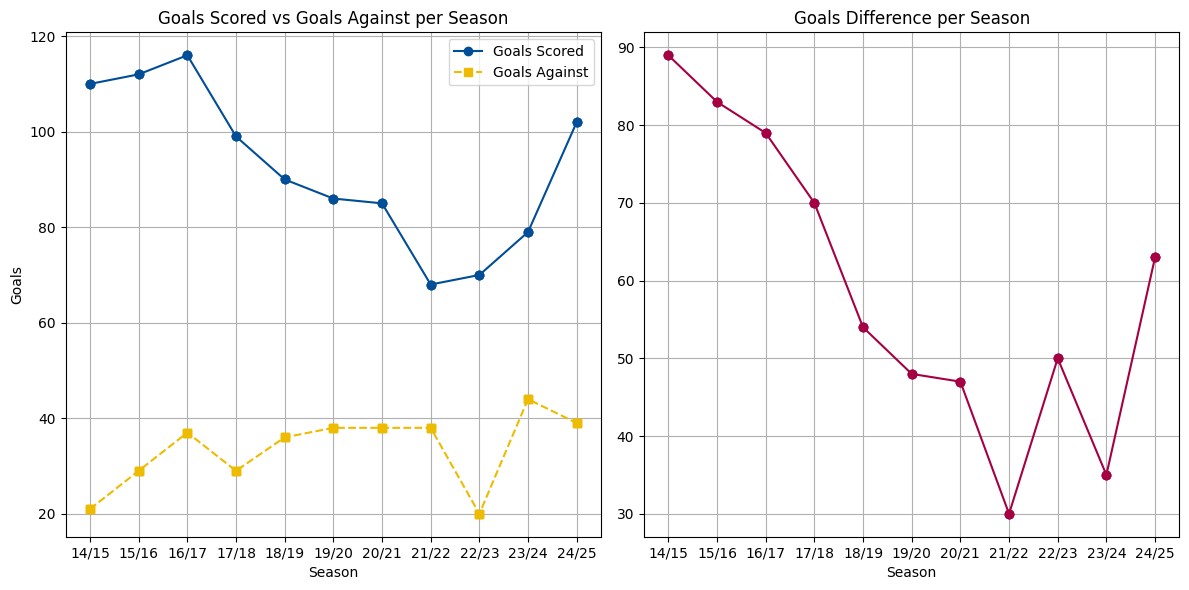

In [4]:
## ========== PLOT 2: Goals For & Goals Against ==========
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(merged_df["Season"], merged_df["Total GF"], marker='o', color='#004D98', label="Goals Scored")
axes[0].plot(merged_df['Season'], merged_df['Total GA'], marker='s', linestyle="--", color='#EDBB00', label='Goals Against')

axes[0].set_title('Goals Scored vs Goals Against per Season')
axes[0].set_ylabel('Goals')
axes[0].set_xlabel('Season')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(merged_df['Season'], merged_df['Domestic GD'], marker='o', color='#A50044', label='Goals Difference')
axes[1].set_title("Goals Difference per Season")
axes[1].set_xlabel("Season")
axes[1].grid(True)
plt.tight_layout()

#### INSIGHTS: How does the number of Goals-For and Goals-Against reflect FC Barcelona defensive weakness?
- The line charts above illustrate goals distribution of FCB over the past 10 years. As shown by 2nd chart, the goal difference (goals scored - goals against) decreased gradually after their peak season in 14/15. This indicates that although the team maintained relatively strong attacking outcomes, they simultaneously conceded more goals, revealing a recurring defensive weakness in the years following their dominance. 
- In particular, the 21/22 season stands out as a low point. During this season, FCB scored the least goals in the last decade while conceding one of the highest totals (38, secondly to 44). As the result, the goals difference of this season dropped to the lowest level, highlighting that this was a period of significant instability and  decline in overall performance.
- The 22/23 season marked the turning point and the beginning of a rebuilding era. The goal difference significantly increased  while the goals against them reached the lowest in 10 years. This improvement coincided with a managerial change in the middle of the previous season when Xavi Hernandez came and replaced his colleague Sergi Barjuan as the manager of FCB, indicating a shift in tactical structure and defensive discipline. 
- However, the subsequent 23/24 season raised questions about their consistency. Despite tactical improvement, the team’s defensive performance deteriorated, with goals conceded reaching their highest level in a decade (44). This suggests that besides manager — other factors such as player dependency or financial situation - may have influenced their on-pitch performance, especially in defense.

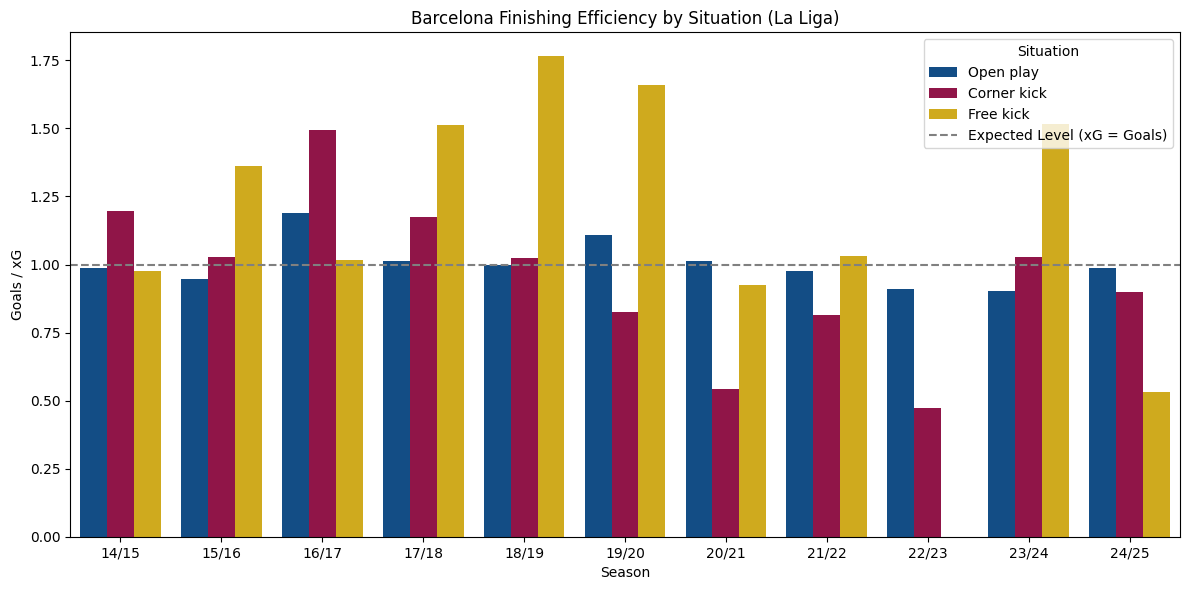

In [5]:
## ========== PLOT 3: Goals and Expected Goals ==========
plt.figure(figsize=(12, 6))
merged_df['Finishing_eff'] = merged_df['GF'] / merged_df['xG']
sns.barplot(x='Season', y='Finishing_eff', hue='Ball Situation', data=merged_df, palette=['#004D98','#A50044', '#EDBB00'])
plt.axhline(1, color='gray', linestyle='--', label='Expected Level (xG = Goals)')
plt.title('Barcelona Finishing Efficiency by Situation (La Liga)')
plt.ylabel('Goals / xG')
plt.legend(title='Situation')
plt.tight_layout()


#### Insights: FC Barcelona finishing efficiency based on Expected-Goals (xG) and goals for (GF)
- The analysis of FC Barcelona finishing efficiency based on Goals-For (GF) and Expected Goals (xG) across different ball situation reveal dinstinct patterns in the team's attacking performance over the last 10 years. Efficiency is measured as the ratio of Goals-For (GF) to Expected Goals (xG), where a ratio above 1 indicates overperformance and below 1 indicates underperformance.
- **Open play:** Involving the play of live ball, usually contributes the majority of goals of any team. As it is shown in this bar plot, FCB does not always take good advantages of created chances. Between 2014 and 2019, FCB’s open play efficiency averaged 1.02 GF/xG, just slightly above the expected level. This essentialy means that while they created substantial number of chances and take many shots, fewer were converted into valid goals. After the season 19/20, their efficiency declined to an average of 0.95 GF/xG. In the 24/25 season, even when their Goals-For significantly increased, their efficiency remained below 1, highlighting that their conversion rate could still be improved.
- **Set pieces:** Corner kick and freekick are usually parts of set piece but analyzing them separately will provides better understanding and visualization of their performance trend. FCB showed strong execution in dead-ball scenarios between 2014 and 2019, especially in freekick with an average of 1.38 GF/xG. However, the finishing efficiency in set pieces went below expectation after the season 19/20 and fluctuated in the last few years. This might be the results of Messi's departure as he was the one who took the primary responsibility of the freekick in the squad, and after his transfer to PSG, Barcelona barely scored a goal from a free kick.
- **Overall trend:** Across all ball situations, FC Barcelona maintained strong attacking efficiency from 2014 to 2019, with most GF/xG ratios were at or above 1. However, finishing inefficiency, particularly post-2020, may have cost Barcelona decisive points both domestically and in Europe. 

In [1]:

# stats visualize
# fig, ax1 = plt.subplots(figsize=(12,6))

# ========== PLOT 3: Goals and Rank ==========
# ax1.plot(df2["Season"], df2["UCL GF"], marker='o', color='blue', label="Goals")
# ax1.set_xlabel("Season")
# ax1.set_ylabel("Goals", color='blue')
# ax1.tick_params(axis='y', labelcolor='blue')
# ax1.grid(True)

# # plot rank on another y axis
# ax2 = ax1.twinx()  
# ax2.plot(df2["Season"], df2["Stage Reached"], marker='s', color='red', linestyle='--', label="Rank")
# ax2.set_ylabel("Stage Progression", color='red')
# ax2.invert_yaxis()  
# ax2.tick_params(axis='y', labelcolor='red')

# # add title and legend
# fig.suptitle("Total Goals and Rank per Season")
# fig.tight_layout()

plt.figure(figsize=(12,6))
plt.plot(df2["Season"], df2["UCL GF"], marker='o', label="Goals For", color='#004D98')
plt.plot(df2["Season"], df2["UCL GA"], marker='s', label="Goals Against", color='#A50044')
plt.fill_between(df2["Season"], df2["UCL GD"], 0, alpha=0.1, label="Goal Difference", color='#FDB927')
plt.title("FC Barcelona: UEFA Champions League Performance (Goals vs Goals Against)")
plt.xlabel("Season")
plt.ylabel("Goals")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

#### INSIGHTS
- This line chart shows the summary stats of FCB in the UEFA Champions League (UCL), which is considered the most pretigous club-level title in football,  over 10 years from 2014 - 2024. The latest time that they won this competition was 10 years ago, and since then there was a negative fluctuation in their performance. They were eliminated in Quarter-Finals (QF) for 3 consecutuve years after becoming a champion in the 14/15 season. They got into Semi-Finals in 18/19 but the results were even worse the following years, paticularly in 21/22 and 22/23. If we look more closely here, we will see there are two points plotted in the line in these 2 seasons. This happened because FCB was demoted to the UEFA Europa League (UEL) after failing the group stage of the UCL, and again they got elimninated in the QF (of the UEL) in 21/22 and could not even pass the Knock-Out stages (Round of 32 of the UEL) in 22/23. In the next 2 seasons, although they were able to come back and play at the UCL, they still failed at Quarter and Semi Finals.
- There was a key point here is that, it has been 10 years since the last time they won this reputable title, and they lost 8 times out of 10 at the Knock-Out games (QF and SF) despite how well they performed in the previous stages. If we look at the 24/25 season, they scored extremely many goals, many more compared to the season that they last won, and still only ended reaching the Semi-Finals. 
- 

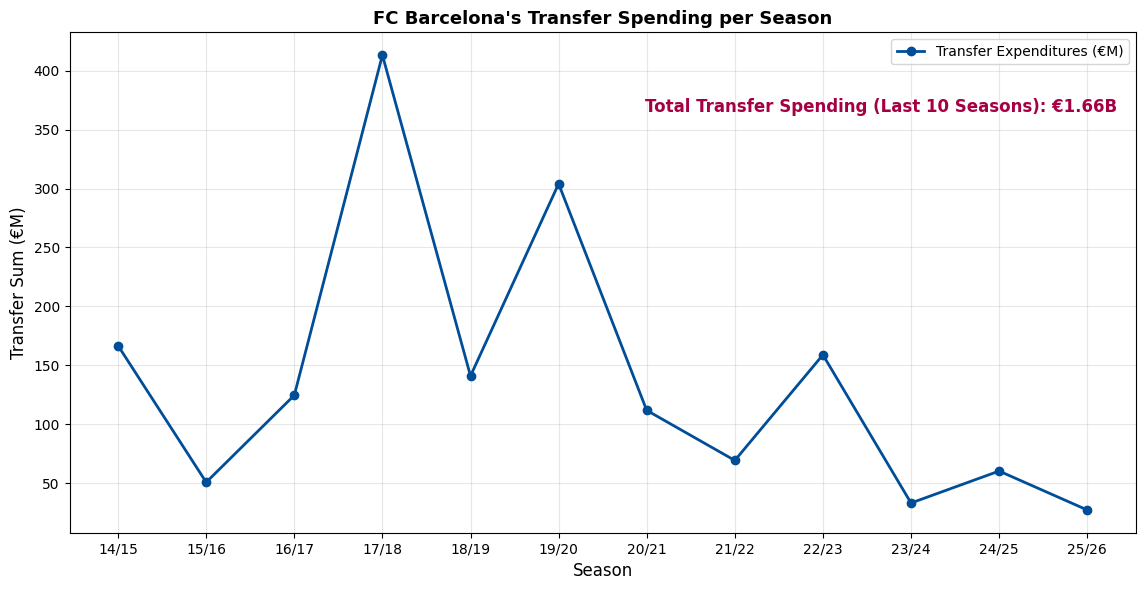

In [7]:
# Financial Analysis
## ========== PLOT 1: Transfer Spending ==========
plt.figure(figsize=(12, 6))
plt.plot(
    df5["Season"],
    df5["Transfer sum"],
    marker="o",
    color="#004D98",
    linewidth=2,
    label="Transfer Expenditures (€M)"
)
# Add chart elements
plt.title("FC Barcelona's Transfer Spending per Season", fontsize=13, weight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Transfer Sum (€M)", fontsize=12)
total_spending = df5["Transfer sum"].sum()/1000

# Add annotation
plt.text(
    0.54, 0.84, f"Total Transfer Spending (Last 10 Seasons): €{total_spending:.2f}B", transform=plt.gca().transAxes,
    fontsize=12, color="#A50044", weight='bold'
)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

#### Insight: 
- The analysis of FC Barcelona’s transfer expenditures over the past decade offers valuable insights into the club’s financial stability and management strategy, both of which have significantly influenced on-field performance.
  - From 2014 to 2020, the club maintained a stable financial status, reflected in consistently high levels of transfer spending and the freedom to pursue marquee signings. However, this period of apparent prosperity also exposed weaknesses in long-term recruitment strategy. Between 2016 and 2020, Barcelona were among Europe’s most active spenders in the transfer market - investing approximately €1.1 billion out of a total €1.66 billion spent across the last 11 years.
  - The 17/18 season stands out as the turning point. Following Neymar’s record-breaking transfer to Paris Saint-Germain, the club responded with a series of high-profile and high-cost signings in an attempt to replace his impact. Transfer expenditures that year were three times higher than the previous season and more than double the following one. Yet, despite such heavy investment, Barcelona’s performance failed to show proportional improvement, highlighting inefficiencies in recruitment strategy, talent integration, and financial management.
  - From the 20/21 season onward, the club’s situation changed drastically. Years of excessive spending, compounded by the COVID-19 pandemic and structural mismanagement, had left FC Barcelona in severe debt. Consequently, their transfer activity declined sharply as the club was forced to comply with La Liga’s Squad Cost Limit - a strict salary cap regulation that constrained spending. To deal with these constraints, Barcelona became highly rely on free transfers, loan signings, and the promotion of young players from their renowned La Masia academy, marking a strategy of shifting towards a cost-effective squad management.
- Overall, this analysis demonstrates that Barcelona’s current financial struggles are not isolated incidents but rather the cumulative result of poor transfer market management during their most lavish years. The reduction in transfer expenditure after 2020 was less a matter of choice than a reflection of financial necessity, marking the beginning of a new, restrictive phase shaped by La Liga’s economic controls.


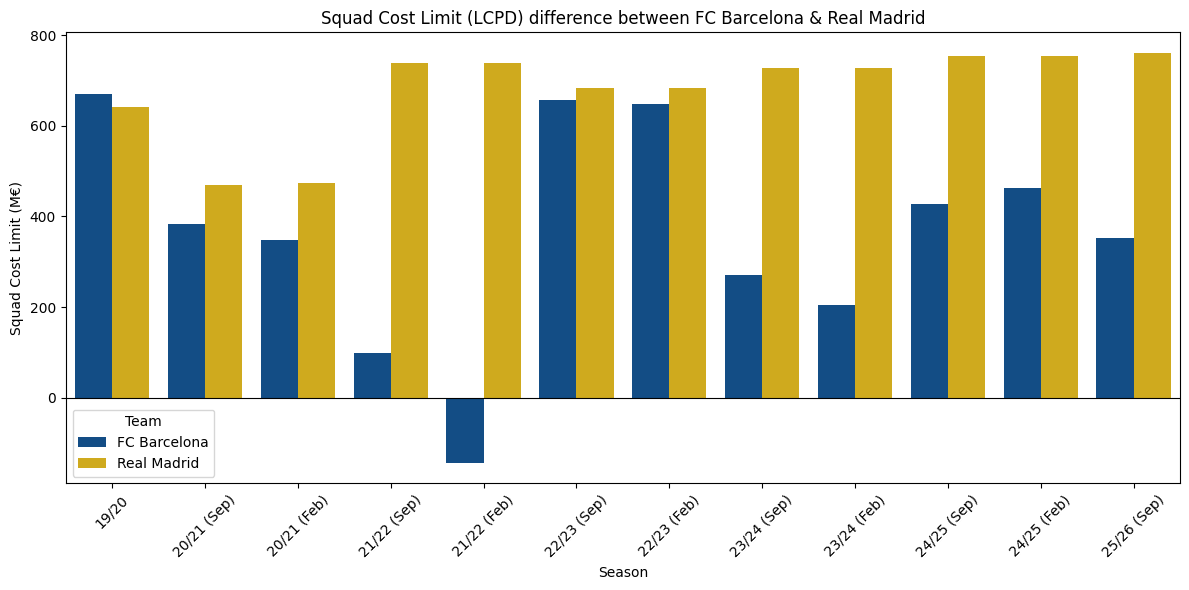

In [8]:
## ========== PLOT 2: Squad Cost Limit Comparison ==========
plt.figure(figsize=(12, 6))
sns.barplot(x='Season', y='Squad Cost Limit', hue='Team', data=df4, palette=['#004D98','#EDBB00'])
plt.title('Squad Cost Limit (LCPD) difference between FC Barcelona & Real Madrid')
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel('Squad Cost Limit (M€)')
plt.legend(title="Team")
plt.xticks(rotation=45);
plt.tight_layout()

#### Insights: Comparison of Squad Cost Limit between FC Barcelona and Real Madrid
- The analysis of FC Barcelona's financial situation can be interpreted further by its Squad Cost Limit in La Liga compared to their rival, Real Madrid. While performance data and transfer data were available from 2014 onward, official financial data (Squad Cost Limit) is only published from 19/20 season. Therefore, the financial analysis focuses on the most recent six seasons to provide contextual understanding of the club’s constraints. Squad Cost Limit (LCPD) is a measure set by La Liga which define the maximum amount a club may spend on registered players, coaching staff, and youth system expenses (including salaries, amortizations, and agent fees). La Liga is widely known for enforcing one of the strictest Financial Fair Play (FFP) regulations among Europe’s top leagues, compelling clubs to balance spending and revenue. Exceeding the Squad Cost Limit or violating FFP rules can trigger sanctions or restrictions on new signings, directly affecting on-pitch competitiveness.
- From 2019 to current season, FC Barcelona's Squad Cost Limit experienced major fluctuations that closely reflects their sporting performance trends:
  - Barcelona record their highest-ever Squad Cost Limit of €671M in 19/20 season, even surpassing Real Madrid. The club was financially stable and competitive across all fronts.
  - In the 20/21 season, it is inevitable that both team witnessed a decline in their limit due COVID-19 pandemic-related revenue issues. However, Barcelona's situation deteriorated faster, making the onset of deeper structural issues. 
  - In February 2022 (Winter Transfer Market), Barcelona suffered a severe crisis as they entered a negative limit, forcing them to operate under 1:4 rule - allowing only 25% reinvestment of income. This period coincided with Messi’s departure as a free transfer and the team’s lowest competitive point in recent history, bringing the club's crisis in the spotlight.
  - In the 22/23 season, the club saw a temporary recovery of the limit due to the activation of the four "economic fever", including the sales of 25% of future television rights and other assets of the club such as 49% of Barça Studio. The limit rebounded to €656M, supporting key transfer and winning the La Liga title of the season.
  - However, financing the club's future can only exchange for short-term liquidity. Although the Squad Cost Limit initially improved in 24/25, it declined slightly this current season (25/26). Unvalidated revenue from the sale of VIP seats and delayed return to the Spotify Camp Nou reduced expected income, limiting summer transfer signings. 
- Observing more carefully we can see that FC Barcelona often experienced adjustment in the Squad Cost Limit between Summer and Winter Transfer Market while their biggest rival - Real Madrid, in the other hand, after briefly declining during pandemic period, recovered rapidly and remained stable. While financially powerful clubs like Real Madrid, Manchester City or PSG sustained competitiveness through stable investment and continuous development, Barcelona’s FFP restrictions limited similar strategic flexibility and their squad renewal ability, causing their inconsistent.
- Overall, the **correlation between financial constraints and team performance** is evident: Financial restrictions have reduced squad's depth as the club is unable to sign high-quality players, increasing dependence on current key players. This essentially means that when core players rested or injured, the team usually failed to remain effectiveness in their tactical structure, and encouter more difficulties on pitch. FC Barcelona's challenges extends beyond tactics - the club **must restore its long-term financial stability** to rebuild their position as one of top-tier clubs and regain their competitiveness against other rivals.

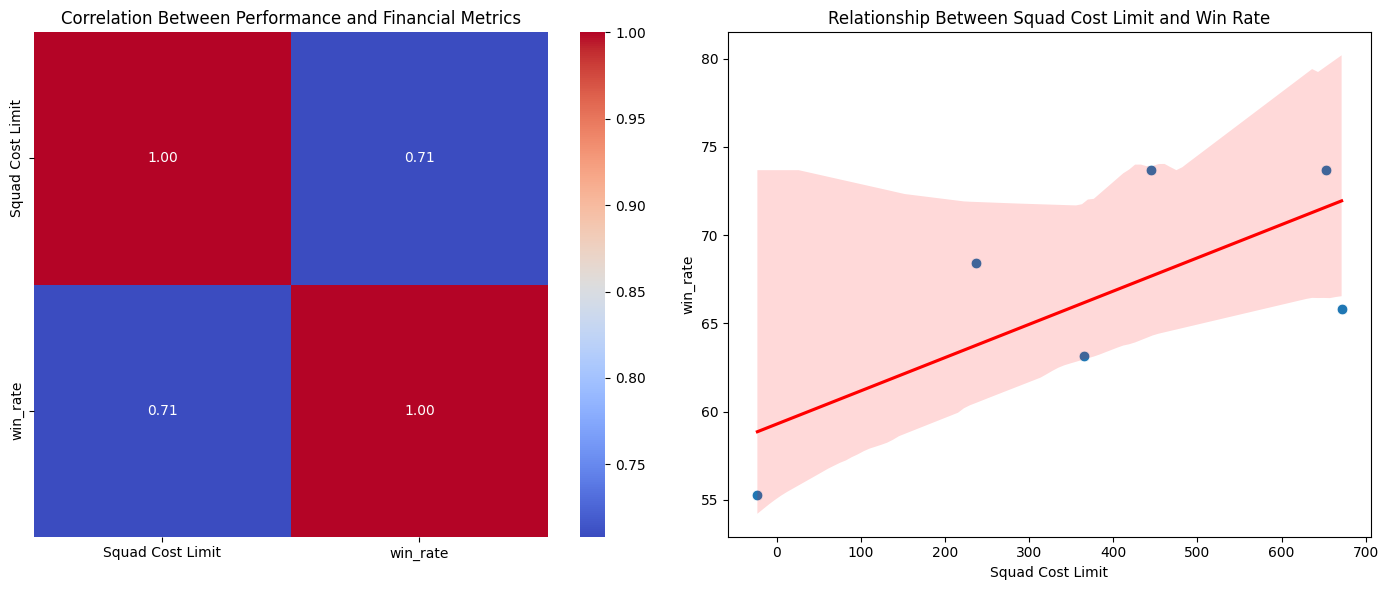

In [12]:
# Make sure df5 has one row per season
merged_df_single = merged_df.drop_duplicates(subset='Season').reset_index(drop=True)
merged_df_single.drop(['Squad', 'Domestic Comp', 'Ball Situation', 'GF', 'GA', 'xG', 'xGA'], axis=1, inplace=True)
merged_df_single['win_rate'] = (merged_df_single['Domestic W'] / merged_df_single['Domestic Match Played'] * 100).round(2)
summary = merged_df_single[['Season', 'Total GF', 'Total GA', 'Domestic Rank', 'win_rate']].merge(df5, on='Season', how='left')

fcb_df = df4[df4['Team'] == 'FC Barcelona'].copy()
fcb_df['Season_std'] = fcb_df['Season'].str[:5]
fcb_df.drop(['Season'], axis=1)
fcb_df = (fcb_df.groupby('Season_std', as_index=False)[['Squad Cost Limit']] .mean())
fcb_df.rename(columns={'Season_std' : 'Season'}, inplace=True) 
summary = summary.drop(list(range(0, 5))).reset_index(drop=True)
correlation = summary.merge(fcb_df, on='Season', how='left')
correlation


correlation = correlation.copy()

# Convert 'Domestic Rank' to numeric
correlation['Domestic Rank Numeric'] = correlation['Domestic Rank'].str.replace(r'(st|nd|rd|th)', '', regex=True).astype(int)
# Select numeric columns for correlation
numeric_cols = [ 'Squad Cost Limit', 'win_rate']

corr = correlation[numeric_cols].corr()

# Plot heatmap
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Heatmap on the first subplot
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=axes[0])
axes[0].set_title("Correlation Between Performance and Financial Metrics")

# Scatter + regression on the second subplot
sns.scatterplot(data=correlation, x='Squad Cost Limit', y='win_rate', ax=axes[1], s=60)
sns.regplot(data=correlation, x='Squad Cost Limit', y='win_rate', ax=axes[1], scatter=False, color='red')
axes[1].set_title("Relationship Between Squad Cost Limit and Win Rate")

plt.tight_layout()
plt.show()

